In [ ]:
# Previous notebook was getting long

In [ ]:
# Required imports
import json
import re
import zipfile as zp
import pandas as pd
import numpy as np
import emoji
import random
import pygal
import user_agents
#flask example (example.zip musi być w katalogu głównym)
from util import *

# from user_agents import parse

# # Let's start from an old, non touch Blackberry device
# ua_string = 'BlackBerry9700/5.0.0.862 Profile/MIDP-2.1 Configuration/CLDC-1.1 VendorID/331 UNTRUSTED/1.0 3gpp-gba'
# user_agent = parse(ua_string)
# user_agent.is_mobile # returns True
# user_agent.is_tablet # returns False
# user_agent.is_touch_capable # returns False
# user_agent.is_pc # returns False
# user_agent.is_bot # returns False
# str(user_agent) # returns "BlackBerry 9700 / BlackBerry OS 5 / BlackBerry 9700"


In [ ]:
def format_user_agent(t):
    t = user_agents.parse(t)
    dev = str(t.device.brand) + ' ' + str(t.device.model)
    if t.device.brand == None and t.device.model == None:
        if t.is_pc:
            dev = 'PC'
        else:
            dev = 'Other'
    # t.os.family, t.browser.family, dev
    return  dev + ' / ' + str(t.os.family) + ' / ' + t.browser.family

In [ ]:
# zip_path = "/home/jacek/Pobrane/Okon_Slowacki_30_11_2020.zip"
zip_path = "/home/jacek/Pobrane/facebook-jacekstasiak75 222.zip"
# zip_path = "/home/jacek/Pobrane/win10 unpacked/facebook-okoń 28-12-20.zip"
# zip_path = "/home/jacek/Pobrane/facebook-janpodkowa98.zip"

data = None
frens = None
logins = None
acc_activity = None
with zp.ZipFile(zip_path) as zip:
    data = gen_pandas_table(zip)

    folders = get_structure(zip)
    fb_activity_path = None
    acc_activity_path = None
    
    for i in folders['security_and_login_information']['__files']:
        if i[0] == 'your_facebook_activity.json':
            fb_activity_path = i[1]
        elif i[0] == 'account_activity.json':
            acc_activity_path = i[1]
    
    log_data = pd.DataFrame()
    with zip.open(fb_activity_path) as f:
        jsec = json.loads(f.read())
        act_type = []
        act_time = []
        for k, v in jsec['last_activity']['last_activity_time'].items():
#             print(k)
            for i in v['activity_by_day']:
                act_type.append(k)
                act_time.append(i)
        log_data = pd.DataFrame({'source': act_type, 'time': act_time})
        log_data.time = pd.to_datetime(log_data.time, unit='s')
    logins = log_data
    
    
    with zip.open(acc_activity_path) as f:
        actions = []
        times = []
        agents = []
        jdata = json.loads(f.read())
        for j in jdata['account_activity']:
#             print(j['action'] + ", " + j['user_agent'])
            actions.append(j['action'])
            parsed_agent = format_user_agent(j['user_agent'])
#             parsed_agent = str(user_agents.parse(j['user_agent']))
#             print(j['user_agent'])
#             if 'Facebook' in parsed_agent:
#                 parsed_agent = re.sub('Facebook.*', 'Facebook', parsed_agent)
                
            agents.append(str(parsed_agent))
            times.append(j['timestamp'])
            
        acc_activity = pd.DataFrame({'time': times, 'agent': agents, 'action': actions})
        acc_activity.time = pd.to_datetime(acc_activity.time, unit='s')
        
#         print(jsec)
# logins
# logins.groupby(logins.source).count()
# messages_table = data['messages']

In [ ]:
# print(data.keys())
acc_act = data['account_activity']
acc_act.agent.unique()
device_usage = acc_act.groupby(acc_act.agent).action.count().sort_values(ascending=True)
total_uses = device_usage.sum()

chart = pygal.HorizontalBar(show_legend=False)
chart.x_labels = list(device_usage.index)
chart.add('', [ (i / total_uses) * 100 for i in list(device_usage)])
# chart.y_title = 'device name'
chart.x_title = '% of usage'

# hour_active = acc_act[(acc_act.action == 'Login') | (acc_act.action == 'Session updated')].groupby(acc_activity.time.dt.hour)
# hour_active = hour_active.action.count()
# total_hours = hour_active.sum()
# print(total_hours)
# hour_active = dict(hour_active)
# for i in range(24):
#     if not i in hour_active:
#         hour_active[i] = 0
# # sorted(hour_active.items(), key=lambda x: x[0])
# chart = pygal.Bar(show_legend=False)
# chart.x_labels = [i for i in range(24)]
# chart.add('', [(hour_active[i] / total_hours) * 100 for i in range(24)])
# chart.y_title = '% of activity'
# chart.x_title = 'hour'
chart


#20:13

In [83]:
mess = data['messages']
# mess = mess[(mess.sender == 'Wiktor Kania') & (mess.thread_type == 'Regular')].dropna()
mess


,conversation,thread_type,sender,time,content
0,Artur Kotlarek,Regular,Jacek Stasiak,2017-04-11 11:08:11.614,Przywitaj się z Arturem.
1,Artur Kotlarek,Regular,Jacek Stasiak,2017-01-10 11:43:58.622,None
2,Artur Kotlarek,Regular,Artur Kotlarek,2016-09-24 17:40:14.375,Możecie teraz porozmawiać ze sobą w Messengerze.
0,Łukasz Stawicki,Regular,Łukasz Stawicki,2018-01-04 21:54:51.274,No to na za tydzien odamy
1,Łukasz Stawicki,Regular,Jacek Stasiak,2018-01-04 20:11:44.781,Też bym wolał za tydzień
...,...,...,...,...,...
22,SOS Damnte,RegularGroup,Piotr Schlesinger,2019-06-10 11:45:48.092,Piotr utworzył grupę.
0,Użytkownik Facebooka,Regular,Jacek Stasiak,2017-04-11 11:08:11.572,Właśnie dołączono do Messengera.
1,Użytkownik Facebooka,Regular,Użytkownik Facebooka,2016-12-07 13:52:40.101,Wypełnij ankietę na grupie Bezlitosnych inform...
2,Użytkownik Facebooka,Regular,Użytkownik Facebooka,2016-09-07 18:44:13.066,Możecie teraz porozmawiać ze sobą w Messengerze.


In [196]:
# k = 'Robie te krzyze z 7 dzialu. dżak wykminic w ktorym miejscu dwa krzyze sie zlacza?'
# k = 'eee co tam'
# a = list(filter(lambda i: len(i) > 0, re.split(r'[\s,.?!]', k))) # Dzieli zdanie na słowa i usuwa puste stringi.
def get_messages_stats(mess):
    n_messages = len(mess)
    msg_with_punct = sum(1 for k in mess if re.findall(r'[,.?!;:]', k)) # Wiadomości ze znakami interpunkcyjnymi
#     print(n_messages, msg_with_punct)
    msg_lens = [len(list(filter(lambda i: len(i) > 0, re.split(r'[\s,]', i)))) for i in mess if i is not None] # liczba słów w wiadomości.
    avg_word_count = sum(msg_lens)/len(msg_lens)

    sentences = [] # 1 - zdanie zaczęte wielką literą, 0 - zdanie zaczęte niewielką literą
    for s in mess:
        t = [1 if i.strip()[0].isupper() else 0 for i in list(filter(lambda i: len(i) > 0, re.split(r'[.?!]', s)))] # zdania w wiadomości
        sentences.extend(t)

    stats = (msg_with_punct, (msg_with_punct / n_messages) * 100, sum(sentences), (sum(sentences)/len(sentences)) * 100, avg_word_count)
    return stats

print("Zdania ze znakami interpunkcyjnymi, <- %, Zdania zaczęte wielką literą, <- %, Średnia liczba słów w wiadomości")
# get_messages_stats(mess.content)
# mess.content

Zdania ze znakami interpunkcyjnymi, <- %, Zdania zaczęte wielką literą, <- %, Średnia liczba słów w wiadomości


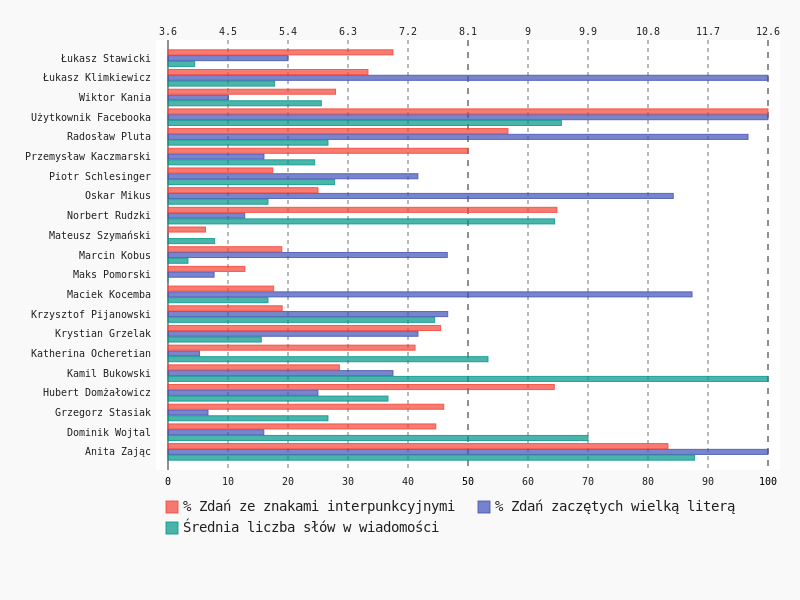

In [204]:
mess = data['messages']
# mess = mess[(mess.sender == 'Wiktor Kania') & (mess.thread_type == 'Regular')].dropna()

user_stats = {}

messes = mess[(mess.thread_type == 'Regular') & (mess.sender != data['username'])].dropna()
for conv, msgs in messes.groupby(messes.conversation):

#     if msgs.content is not None and conv == 'Wiktor Kania':
    if msgs.content is not None and len(msgs.content) > 1:
        user_stats[conv] = get_messages_stats(msgs.content)

df1 = [[], [], [], [], [], []]

for k, v in user_stats.items():
    df1[0].append(k)
    for i, iv in enumerate(v, start=1):
        df1[i].append(iv)
# df = pd.DataFrame({'name': df1[0], "Zdania ze znakami interpunkcyjnymi": df1[1],'<- %': df1[2], 'Zdania zaczęte wielką literą': df1[3], '<- %': df1[4], 'Średnia liczba słów w wiadomości': df1[5]})
df = pd.DataFrame({'name': df1[0], "zn_int": df1[1],'% zn_int': df1[2], 'zd_wl': df1[3], '% zd_wl': df1[4], 'avg_word': df1[5]})
df = df.round({'% zn_int': 2, '% zd_wl': 2, 'avg_word': 1})

chart = pygal.HorizontalBar(legend_at_bottom=True)
chart.x_labels = list(df.name)
chart.add('% Zdań ze znakami interpunkcyjnymi', df['% zn_int'])
chart.add('% Zdań zaczętych wielką literą', df['% zd_wl'])
chart.add('Średnia liczba słów w wiadomości', df['avg_word'], secondary=True)
chart



In [203]:

friends_avg = df.mean()
friends_avg
your_stats = get_messages_stats(mess[(mess.thread_type == 'Regular') & (mess.sender == data['username'])].dropna().content)
# '% Zdań ze znakami interpunkcyjnymi', df['% zn_int'])
# chart.add('% Zdań zaczętych wielką literą', df['% zd_wl'])
# chart.add('Średnia liczba słów w wiadomości
xdpd = pd.DataFrame(
    {
        '': ['Średnia znajomych', 'Twoje statystyki'],
        '% Zdań ze znakami interpunkcyjnymi': [friends_avg['% zn_int'], your_stats[1]],
        '% Zdań zaczętych wielką literą': [friends_avg['% zd_wl'], your_stats[3]],
        'Średnia długość zdania': [friends_avg['avg_word'], your_stats[4]],
    })

xdpd = xdpd.set_index('')
xdpd = xdpd.round({'% Zdań ze znakami interpunkcyjnymi': 2, '% Zdań zaczętych wielką literą': 2, 'Średnia długość zdania': 1})
xdpd

,% Zdań ze znakami interpunkcyjnymi,% Zdań zaczętych wielką literą,Średnia długość zdania
,,,
Średnia znajomych,40.04,42.94,6.8
Twoje statystyki,36.35,4.48,6.7
